In [2]:
%matplotlib inline

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from scipy.interpolate import spline

import logisticRegression as lr

In [5]:
#set index to passenger ID
#ignore unwanted columns when reading in 
trainingData = pd.read_csv('titanic-dataset-train.csv', index_col='passengerid', usecols=['passengerid', 'pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked'])
testingData = pd.read_csv('titanic-dataset-test.csv', index_col='passengerid', usecols=['passengerid', 'pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked'])

In [7]:
#useful pclass, sex, age, maybe sibsp?
#Not so useful - name, ticket, home.dest... 

#trainingData
#type(trainingData)

In [8]:
print('Total Passengers in Training set: ' + str(len(trainingData)))
print('Total Passengers in Testing set: ' + str(len(testingData)))

Total Passengers in Training set: 1000
Total Passengers in Testing set: 309


In [9]:
died = trainingData['survived'].count() - trainingData['survived'].sum()
survived = trainingData['survived'].sum()


    
print('Died:  ' + str(died))
print('Survived:  ' + str(survived))

print(str(died/len(trainingData)*100) + " percent death rate")

Died:  621
Survived:  379
62.1 percent death rate


In [10]:
trainingData.isnull().sum()

pclass        0
survived      0
sex           0
age         201
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64

In [11]:
testingData.isnull().sum()

pclass       0
survived     0
sex          0
age         62
sibsp        0
parch        0
fare         1
embarked     0
dtype: int64

# Fixing Variables

In [12]:
def fixAges(passenger):
    
    age = passenger['age']
    pclass = passenger['pclass']
    
    if( np.isnan(age) and not (np.isnan(pclass)) ):
        #checking by class to assign an average age
        if(pclass == 1):
            return int(np.nanmean(trainingData['age'][trainingData['pclass'] == 1]))
        elif(pclass == 2):                
            return int(np.nanmean(trainingData['age'][trainingData['pclass'] == 2]))
        else:
            return int(np.nanmean(trainingData['age'][trainingData['pclass'] == 3]))
    else:
        return age

In [14]:
trainingData['age'] = trainingData.apply(fixAges, axis=1)
testingData['age'] = testingData.apply(fixAges, axis=1)

In [15]:
trainingData.isnull().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    2
dtype: int64

In [16]:
testingData.isnull().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        1
embarked    0
dtype: int64

In [18]:
trainingData = trainingData.dropna()
testingData = testingData.dropna()

In [20]:
print('Total Passengers in Training set: ' + str(len(trainingData)))
print('Total Passengers in Testing set: ' + str(len(testingData)))

Total Passengers in Training set: 998
Total Passengers in Testing set: 308


In [13]:
# must convert categorical/string variables to dummy/numerical indicators

In [21]:
# converting sex column to 1 for male and 0 for female

#trainingData['Sex'] = trainingData['Sex'].apply(lambda sex: 1 if sex=='male' else 0)
#above recieves warning

trainingData.loc[:, 'sex'] = trainingData.loc[:, 'sex'].apply(lambda sex: 1 if sex=='male' else 0)
testingData.loc[:, 'sex'] = testingData.loc[:, 'sex'].apply(lambda sex: 1 if sex=='male' else 0)

In [22]:
#assign 0-2 for port of embarkation
#  0 for S (Southampton) - 1 for C (Cherbourg) - 2 for Q (Queenstown)

trainingData.loc[:, 'embarked'] = trainingData.loc[:, 'embarked'].apply(lambda port: 0 if port=='S' else 1 if port=='C' else 2)
testingData.loc[:, 'embarked'] = testingData.loc[:, 'embarked'].apply(lambda port: 0 if port=='S' else 1 if port=='C' else 2)

In [24]:
trainingData

,pclass,survived,sex,age,sibsp,parch,fare,embarked
passengerid,,,,,,,,
1,3,0,1,36.0,0,0,0.0000,0
2,2,0,1,21.0,0,0,73.5000,0
3,1,0,1,56.0,0,0,26.5500,0
4,2,0,0,29.0,0,0,21.0000,0
5,3,0,0,43.0,1,6,46.9000,0
6,3,1,0,24.0,2,0,23.2500,2
7,2,1,0,23.0,0,0,13.7917,1
8,1,1,0,38.0,1,0,52.0000,0
9,3,1,0,24.0,1,1,22.3583,1


# Visualization

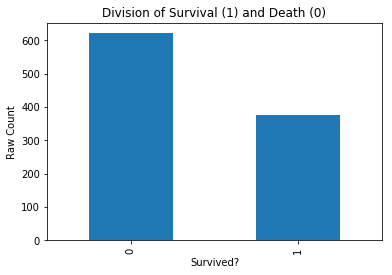

In [25]:
#Pay attention to this
#A 60% accurate model would be unimpressive
trainingData['survived'].value_counts().plot(kind = 'bar')
plt.title('Division of Survival (1) and Death (0)')

plt.xlabel('Survived?')
plt.ylabel('Raw Count')

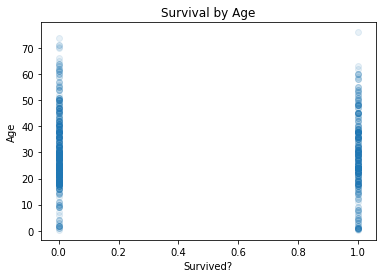

In [26]:
plt.scatter(trainingData['survived'], trainingData['age'], alpha= 0.1)
plt.title('Survival by Age')
plt.ylabel('Age')
plt.xlabel('Survived?')

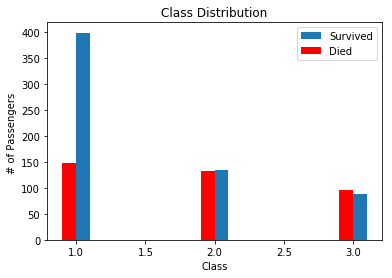

In [27]:
width = 0.1

plt.bar([1,2,3], trainingData['pclass'][trainingData['survived'] == 0].value_counts(), width=width, align='edge')
plt.bar([1,2,3], trainingData['pclass'][trainingData['survived'] == 1].value_counts(), width=-width, color='red', align='edge')

plt.title("Class Distribution")
plt.xlabel('Class')
plt.ylabel('# of Passengers ')
plt.legend(('Survived', 'Died'),loc='best') 

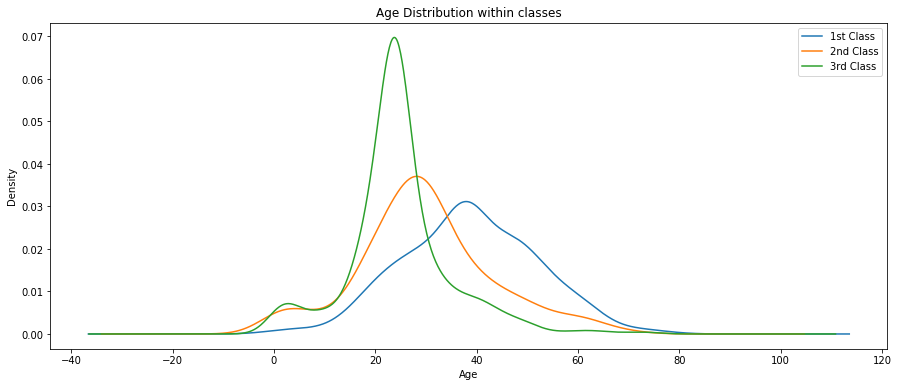

In [28]:
fig = plt.figure(figsize=(15,6))

#kernel density estimation to smoooooth
#older passengers more likely ot be in the more expensive classes
trainingData['age'][trainingData['pclass'] == 1].plot(kind ='kde') 
trainingData['age'][trainingData['pclass'] == 2].plot(kind ='kde')
trainingData['age'][trainingData['pclass'] == 3].plot(kind ='kde')

plt.xlabel("Age")    
plt.title("Age Distribution within classes")

plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 

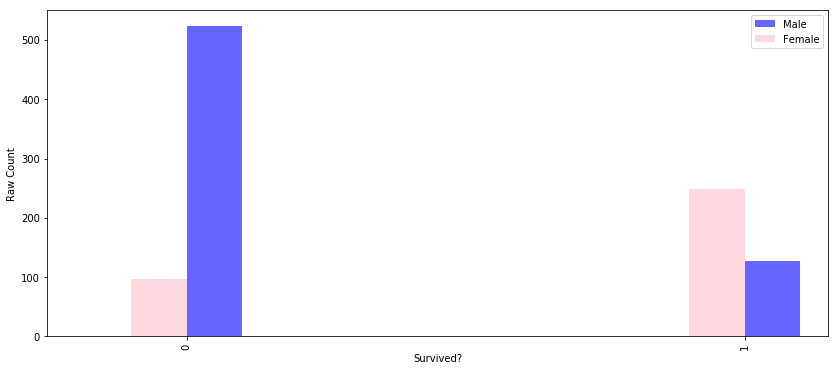

In [29]:
#Gender? 
fig = plt.figure(figsize=(14,6))

maleData = trainingData['survived'][trainingData['sex'] == 1].value_counts().sort_index()
femaleData = trainingData['survived'][trainingData['sex'] == 0].value_counts().sort_index()

maleData.plot('bar', color='blue', alpha=0.6, width=0.10, align='edge')
femaleData.plot('bar', color='pink', alpha=0.6, width=-0.10, align='edge')
plt.legend(('Male', 'Female'),loc='best') 
plt.xlabel('Survived?')
plt.ylabel('Raw Count')


(-0.5, 0.5)

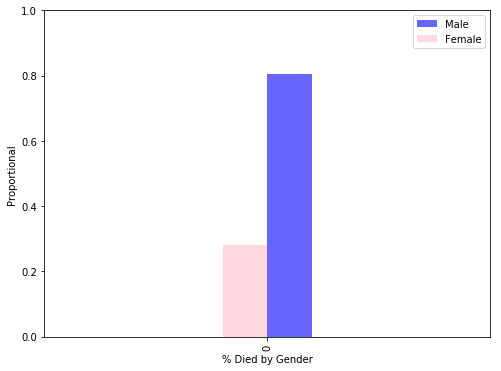

In [30]:
#Percentagewise
#~25% of makes survived and ~85% females 
fig = plt.figure(figsize=(8,6))

maleData = trainingData['survived'][trainingData['sex'] == 1].value_counts().sort_index()
femaleData = trainingData['survived'][trainingData['sex'] == 0].value_counts().sort_index()

(maleData/maleData.sum()).plot('bar', color='blue', alpha=0.6, width=0.10, align='edge')
(femaleData/femaleData.sum()).plot('bar', color='pink', alpha=0.6, width=-0.10, align='edge')

plt.legend(('Male', 'Female'),loc='best') 
plt.xlabel('% Died by Gender')
plt.ylabel('Proportional')
plt.ylim(0.0,1.0)
plt.xlim(-0.5, 0.5)

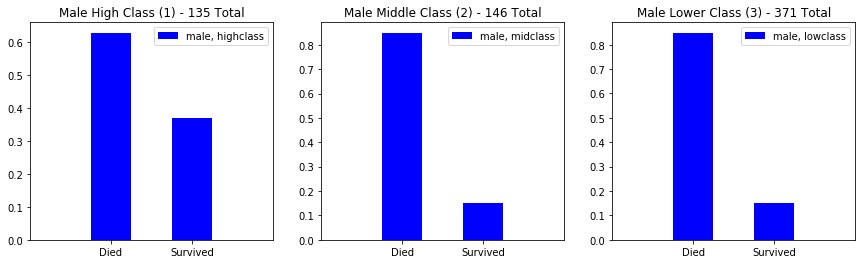

In [31]:
#What about class by gender
fig = plt.figure(figsize=(20,4))

ax0=fig.add_subplot(141)
male_class1 = trainingData['survived'][trainingData['sex'] == 1][trainingData['pclass'] == 1].value_counts()
(male_class1/male_class1.sum()).plot(kind='bar', label='male, highclass', color='blue')
ax0.axes.set_xticklabels(["Died", "Survived"], rotation=0)
ax0.set_xlim(-1, 2)
plt.title("Male High Class (1) - " + str(male_class1.sum()) + " Total") 
plt.legend()

ax1=fig.add_subplot(142)
male_class2 = trainingData['survived'][trainingData['sex'] == 1][trainingData['pclass'] == 2].value_counts()
(male_class2/male_class2.sum()).plot(kind='bar', label='male, midclass', color='blue')
ax1.axes.set_xticklabels(["Died", "Survived"], rotation=0)
ax1.set_xlim(-1, 2)
plt.title("Male Middle Class (2) - " + str(male_class2.sum()) + " Total") 
plt.legend()

ax1=fig.add_subplot(143)
male_class3 = trainingData['survived'][trainingData['sex'] == 1][trainingData['pclass'] == 3].value_counts()
(male_class3/male_class3.sum()).plot(kind='bar', label='male, lowclass', color='blue')
ax1.axes.set_xticklabels(["Died", "Survived"], rotation=0)
ax1.set_xlim(-1, 2)
plt.title("Male Lower Class (3) - " + str(male_class3.sum()) + " Total") 
plt.legend()

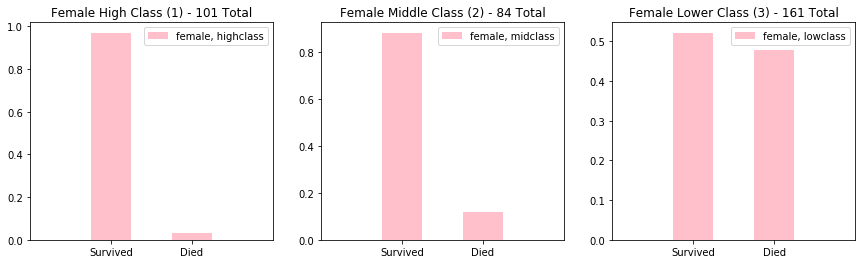

In [32]:
fig = plt.figure(figsize=(20,4))

ax0=fig.add_subplot(141)
female_class1 = trainingData['survived'][trainingData['sex'] == 0][trainingData['pclass'] == 1].value_counts()
(female_class1/female_class1.sum()).plot(kind='bar', label='female, highclass', color='pink')
ax0.axes.set_xticklabels(["Survived", "Died"], rotation=0)
ax0.set_xlim(-1, 2)
plt.title("Female High Class (1) - " + str(female_class1.sum()) + " Total") 
plt.legend()

ax1=fig.add_subplot(142)
female_class2 = trainingData['survived'][trainingData['sex'] == 0][trainingData['pclass'] == 2].value_counts()
(female_class2/female_class2.sum()).plot(kind='bar', label='female, midclass', color='pink')
ax1.axes.set_xticklabels(["Survived", "Died"], rotation=0)
ax1.set_xlim(-1, 2)
plt.title("Female Middle Class (2) - " + str(female_class2.sum()) + " Total") 
plt.legend()

ax1=fig.add_subplot(143)
female_class3 = trainingData['survived'][trainingData['sex'] == 0][trainingData['pclass'] == 3].value_counts()
(female_class3/female_class3.sum()).plot(kind='bar', label='female, lowclass', color='pink')
ax1.axes.set_xticklabels(["Survived", "Died"], rotation=0)
ax1.set_xlim(-1, 2)
plt.title("Female Lower Class (3) - " + str(female_class3.sum()) + " Total") 
plt.legend()

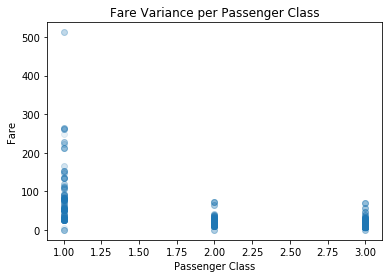

In [33]:
#Are fare and class independent?
plt.scatter(trainingData['pclass'], trainingData['fare'], alpha= 0.1)
plt.title('Fare Variance per Passenger Class')
plt.ylabel('Fare')
plt.xlabel('Passenger Class')

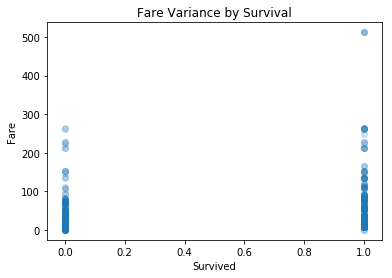

In [34]:
#Did the fare paid effect survival
plt.scatter(trainingData['survived'], trainingData['fare'], alpha= 0.2)
plt.title('Fare Variance by Survival')
plt.ylabel('Fare')
plt.xlabel('Survived')

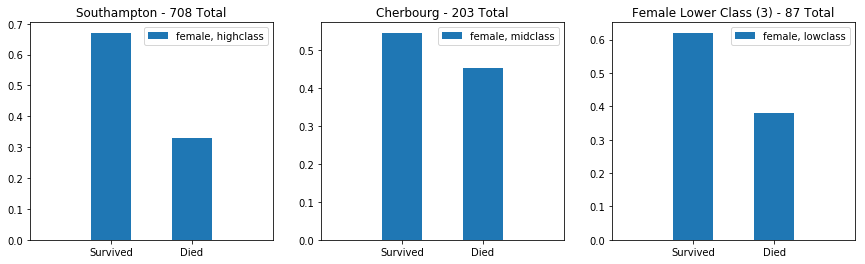

In [35]:
#Did port of embarkation effect survival rate
fig = plt.figure(figsize=(20,4))

ax0=fig.add_subplot(141)
embarked_S = trainingData['survived'][trainingData['embarked'] == 0].value_counts()
(embarked_S/embarked_S.sum()).plot(kind='bar', label='female, highclass')
ax0.axes.set_xticklabels(["Survived", "Died"], rotation=0)
ax0.set_xlim(-1, 2)
plt.title("Southampton - " + str(embarked_S.sum()) + " Total") 
plt.legend()

ax1=fig.add_subplot(142)
embarked_C = trainingData['survived'][trainingData['embarked'] == 1].value_counts()
(embarked_C/embarked_C.sum()).plot(kind='bar', label='female, midclass')
ax1.axes.set_xticklabels(["Survived", "Died"], rotation=0)
ax1.set_xlim(-1, 2)
plt.title("Cherbourg - " + str(embarked_C.sum()) + " Total") 
plt.legend()

ax1=fig.add_subplot(143)
embarked_Q = trainingData['survived'][trainingData['embarked'] == 2].value_counts()
(embarked_Q/embarked_Q.sum()).plot(kind='bar', label='female, lowclass')
ax1.axes.set_xticklabels(["Survived", "Died"], rotation=0)
ax1.set_xlim(-1, 2)
plt.title("Female Lower Class (3) - " + str(embarked_Q.sum()) + " Total") 
plt.legend()

# Implementing Logistic Regression

In [74]:
#features/x's - 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked'
someFeatures = np.array(trainingData.loc[:, ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']])
someTestFeatures = np.array(testingData.loc[:, ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']])

#adding column of ones 
constantCol = np.ones((len(someFeatures),1))
constantTestCol = np.ones((len(someTestFeatures), 1))
features = np.hstack((someFeatures, constantCol))
testFeatures = np.hstack((someTestFeatures, constantTestCol))


#parameters/thetas - 7 features + 1 intercept = 8
thetas = np.zeros((8,1))

#classes/y's - 'survived'
labels = np.array(trainingData.loc[:,['survived']], ndmin=2)

testLabels = np.array(testingData.loc[:,['survived']], ndmin=2)


print("Training Set Shape: " + str(features.shape))
print("Cross Validation Set Shape: " + str(testFeatures.shape))

print("Theta Set Shape: " + str(thetas.shape))

print("Training Labels Set Shape: " + str(labels.shape))
print("Cross Validation Labels Set Shape: " + str(testLabels.shape))

Training Set Shape: (998, 8)
Cross Validation Set Shape: (308, 8)
Theta Set Shape: (8, 1)
Training Labels Set Shape: (998, 1)
Cross Validation Labels Set Shape: (308, 1)


In [75]:
#all being stopped at 500000 iterations and thetas starting at 0.0
#alpha = 0.05  # got to 0.7402 - w/ wild fluctuations
#alpha = 0.01  # got to 0.7695
#alpha = 0.007 # got to 0.8084
#alpha = 0.005 # got to 0.8247
#alpha = 0.003 # got to 0.8117
#alpha = 0.001 # got to 0.8019
#alpha = 1e-4  # got to 0.7987
alpha = 1e-5  # got to 0.6883

minCostDif = 1e-10
maxIterations = 500000
lr.gradientDescent(features, thetas, labels, alpha, minCostDif, maxIterations, testFeatures, testLabels)

Accuracy at 5000 Iterations: 0.642857142857
Accuracy at 10000 Iterations: 0.642857142857
Accuracy at 15000 Iterations: 0.646103896104
Accuracy at 20000 Iterations: 0.649350649351
Accuracy at 25000 Iterations: 0.646103896104
Accuracy at 30000 Iterations: 0.649350649351
Accuracy at 35000 Iterations: 0.655844155844
Accuracy at 40000 Iterations: 0.659090909091
Accuracy at 45000 Iterations: 0.668831168831
Accuracy at 50000 Iterations: 0.672077922078
Accuracy at 55000 Iterations: 0.668831168831
Accuracy at 60000 Iterations: 0.659090909091
Accuracy at 65000 Iterations: 0.659090909091
Accuracy at 70000 Iterations: 0.659090909091
Accuracy at 75000 Iterations: 0.655844155844
Accuracy at 80000 Iterations: 0.652597402597
Accuracy at 85000 Iterations: 0.649350649351
Accuracy at 90000 Iterations: 0.649350649351
Accuracy at 95000 Iterations: 0.649350649351
Accuracy at 100000 Iterations: 0.652597402597
Accuracy at 105000 Iterations: 0.652597402597
Accuracy at 110000 Iterations: 0.652597402597
Accuracy

array([[-0.20928868],
       [-0.4455332 ],
       [-0.00791278],
       [-0.10895382],
       [ 0.03798684],
       [ 0.0127606 ],
       [ 0.11941591],
       [ 0.0221743 ]])